In [20]:
import pandas as pd
import pyfixest as pf
from pyfixest import feols, etable

# 1. Load data
url = "http://dss.princeton.edu/training/Panel101.dta"
mydata = pd.read_stata(url)

# 2. Create DiD variables
mydata["y"] = mydata["y"] / 1_000_000_000
mydata["post"] = (mydata["year"] >= 1994).astype(int)
mydata["treated"] = mydata["country"].isin(["E", "F", "G"]).astype(int)

# 3. Estimate models with different vcov:
models = [
    feols("y ~ treated*post", data=mydata, vcov="iid"),
    feols("y ~ treated*post", data=mydata, vcov="HC3"),
    feols("y ~ treated*post", data=mydata, vcov={"CRV1": "country"}),
    feols("y ~ treated*post", data=mydata, vcov={"CRV3": "country + year"}),
]
display(etable(models,
               headers=["IID", "HC3", "CRV1 (1-Way)", "CRV3 (2-Way)"],
               signif_code=[0.01, 0.05, 0.10]))

# 4. Focus on one model with CRV1 cluster-robust SE:
fit = feols("y ~ treated*post", data=mydata, vcov={"CRV1": "country"})

# --- Additional Inference Methods ---

# (a) Wild Cluster Bootstrap
# Tests the significance of 'treated:post' via a cluster wild bootstrap.
wild_res = fit.wildboottest(param="treated:post", reps=9999, seed=1234)
print("\nWild Bootstrap Inference:\n", wild_res)

# (b) Causal Cluster Variance Estimator
# Involves re-splitting the data and infers significance of 'treated:post'.
ccv_res = fit.ccv(treatment="treated:post", pk=0.05, n_splits=2, seed=929)
print("\nCausal Cluster Variance (CCV) Estimator:\n", ccv_res)

# (c) Randomization Inference
# Randomly permutes (clusters of) 'treated:post' to infer significance.
ri_res = fit.ritest(resampvar="treated:post=0", reps=1000, cluster="country")
print("\nRandomization Inference (RI):\n", ri_res)


GT(_tbl_data=  level_0        level_1                     0                     1  \
0    coef        treated    1.776 <br> (1.128)    1.776 <br> (1.127)   
1    coef           post  2.289** <br> (0.953)  2.289** <br> (0.954)   
2    coef   treated:post  -2.520* <br> (1.456)   -2.520 <br> (1.550)   
3    coef      Intercept    0.358 <br> (0.738)    0.358 <br> (0.812)   
4   stats   Observations                    70                    70   
5   stats      S.E. type                   iid                hetero   
6   stats  R<sup>2</sup>                 0.083                 0.083   

                       2                    3  
0     1.776 <br> (1.394)   1.776 <br> (1.700)  
1   2.289** <br> (0.635)   2.289 <br> (1.205)  
2  -2.520** <br> (1.027)  -2.520 <br> (1.549)  
3     0.358 <br> (1.001)   0.358 <br> (1.534)  
4                     70                   70  
5            by: country     by: country+year  
6                  0.083                0.083  , _body=<great_tables._gt_data.Body object at 0x3423a2d90>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='(3)', column_align='center', column_width=None), ColInfo(var='3', type=<ColInfoTypeEnum.default: 1>, column_label='(4)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x338b74350>, _spanners=Spanners([SpannerInfo(spanner_id='y', spanner_level=1, spanner_label='y', spanner_units=None, spanner_pattern=None, vars=['0', '1', '2', '3'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=['Significance levels: * p < 0.1, ** p < 0.05, *** p < 0.01. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x338cb67d0>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_bord

Module 'wildboottest' not found. Please install 'wildboottest', e.g. via `PyPi`.


UnboundLocalError: cannot access local variable 'WildboottestCL' where it is not associated with a value


Difference-in-Differences Regression Results:
                          IID              HC3     1-Way Cluster      2-Way Cluster
     treated   1.776\n(1.128)   1.776\n(1.094)    1.776\n(1.394)    1.776*\n(1.045)
        post 2.289**\n(0.953) 2.289**\n(0.927) 2.289***\n(0.635)   2.289**\n(0.900)
treated:post -2.520*\n(1.456) -2.520*\n(1.505) -2.520**\n(1.027)   -2.520*\n(1.453)
   Intercept   0.358\n(0.738)   0.358\n(0.789)    0.358\n(1.001)     0.358\n(0.761)
Observations               70               70                70                 70
          R²            0.083            0.083             0.083              0.083
     SE type              iid           hetero       by: country by: country & year

Simple Difference Estimates:
            Comparison Estimate
Before-After (Control)    2.289
Before-After (Treated)   -0.230
Treated-Control (Post)   -0.744
 DiD Estimate (Manual)   -2.520


<Figure size 1000x600 with 0 Axes>

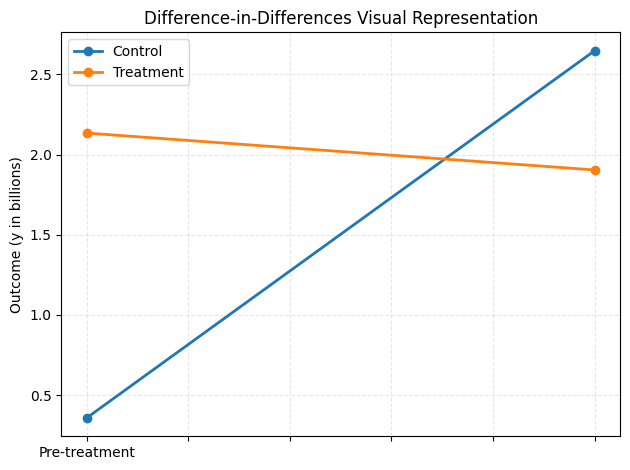

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import matplotlib.pyplot as plt

# Load data
url = "http://dss.princeton.edu/training/Panel101.dta"
data = pd.read_stata(url)

# Create DiD variables
data['y'] = data['y'] / 1_000_000_000  # Scale down y for readability
data['post'] = (data['year'] >= 1994).astype(int)
data['treated'] = data['country'].isin(['E', 'F', 'G']).astype(int)
data['treated_post'] = data['treated'] * data['post']

# Simple regression models
# IID
model_iid = smf.ols("y ~ treated + post + treated_post", data=data).fit()

# Robust (HC3)
model_robust = smf.ols("y ~ treated + post + treated_post", data=data).fit(cov_type='HC3')

# Cluster robust (1-way clustering by country)
model_cluster_1 = smf.ols("y ~ treated + post + treated_post", data=data).fit(
    cov_type='cluster', 
    cov_kwds={'groups': data['country']}
)

# For 2-way clustering (country and year)
# Note: Using a workaround due to limitations with direct 2-way clustering
data['cluster_2way'] = data['country'].astype(str) + "_" + data['year'].astype(str)
model_cluster_2 = smf.ols("y ~ treated + post + treated_post", data=data).fit(
    cov_type='cluster', 
    cov_kwds={'groups': data['cluster_2way']}
)

# Calculate simple differences in means
# Group data
means = data.groupby(['treated', 'post'])['y'].mean().reset_index()
control_before = means[(means['treated'] == 0) & (means['post'] == 0)]['y'].values[0]
control_after = means[(means['treated'] == 0) & (means['post'] == 1)]['y'].values[0]
treat_before = means[(means['treated'] == 1) & (means['post'] == 0)]['y'].values[0]
treat_after = means[(means['treated'] == 1) & (means['post'] == 1)]['y'].values[0]

# Calculate differences
control_diff = control_after - control_before
treat_diff = treat_after - treat_before
post_diff = treat_after - control_after
did_manual = treat_diff - control_diff

# Format coefficients with significance stars
def format_coef(coef, se, pval):
    stars = ""
    if pval < 0.01: stars = "***"
    elif pval < 0.05: stars = "**"
    elif pval < 0.1: stars = "*"
    return f"{coef:.3f}{stars}\n({se:.3f})"

# Create results table
results_table = pd.DataFrame({
    '': ['treated', 'post', 'treated:post', 'Intercept', 
         'Observations', 'R²', 'SE type'],
    'IID': [
        format_coef(model_iid.params['treated'], model_iid.bse['treated'], model_iid.pvalues['treated']),
        format_coef(model_iid.params['post'], model_iid.bse['post'], model_iid.pvalues['post']),
        format_coef(model_iid.params['treated_post'], model_iid.bse['treated_post'], model_iid.pvalues['treated_post']),
        format_coef(model_iid.params['Intercept'], model_iid.bse['Intercept'], model_iid.pvalues['Intercept']),
        str(int(model_iid.nobs)), f"{model_iid.rsquared:.3f}", "iid"
    ],
    'HC3': [
        format_coef(model_robust.params['treated'], model_robust.bse['treated'], model_robust.pvalues['treated']),
        format_coef(model_robust.params['post'], model_robust.bse['post'], model_robust.pvalues['post']),
        format_coef(model_robust.params['treated_post'], model_robust.bse['treated_post'], model_robust.pvalues['treated_post']),
        format_coef(model_robust.params['Intercept'], model_robust.bse['Intercept'], model_robust.pvalues['Intercept']),
        str(int(model_robust.nobs)), f"{model_robust.rsquared:.3f}", "hetero"
    ],
    '1-Way Cluster': [
        format_coef(model_cluster_1.params['treated'], model_cluster_1.bse['treated'], model_cluster_1.pvalues['treated']),
        format_coef(model_cluster_1.params['post'], model_cluster_1.bse['post'], model_cluster_1.pvalues['post']),
        format_coef(model_cluster_1.params['treated_post'], model_cluster_1.bse['treated_post'], model_cluster_1.pvalues['treated_post']),
        format_coef(model_cluster_1.params['Intercept'], model_cluster_1.bse['Intercept'], model_cluster_1.pvalues['Intercept']),
        str(int(model_cluster_1.nobs)), f"{model_cluster_1.rsquared:.3f}", "by: country"
    ],
    '2-Way Cluster': [
        format_coef(model_cluster_2.params['treated'], model_cluster_2.bse['treated'], model_cluster_2.pvalues['treated']),
        format_coef(model_cluster_2.params['post'], model_cluster_2.bse['post'], model_cluster_2.pvalues['post']),
        format_coef(model_cluster_2.params['treated_post'], model_cluster_2.bse['treated_post'], model_cluster_2.pvalues['treated_post']),
        format_coef(model_cluster_2.params['Intercept'], model_cluster_2.bse['Intercept'], model_cluster_2.pvalues['Intercept']),
        str(int(model_cluster_2.nobs)), f"{model_cluster_2.rsquared:.3f}", "by: country & year"
    ]
})

# Simple differences table
diff_table = pd.DataFrame({
    'Comparison': ['Before-After (Control)', 'Before-After (Treated)', 
                  'Treated-Control (Post)', 'DiD Estimate (Manual)'],
    'Estimate': [f"{control_diff:.3f}", f"{treat_diff:.3f}", 
                f"{post_diff:.3f}", f"{did_manual:.3f}"]
})

# Print tables
print("\nDifference-in-Differences Regression Results:")
print(results_table.to_string(index=False))

print("\nSimple Difference Estimates:")
print(diff_table.to_string(index=False))

# Visual representation
plt.figure(figsize=(10, 6))
data_wide = pd.DataFrame({
    'Pre-treatment': [control_before, treat_before],
    'Post-treatment': [control_after, treat_after]
}, index=['Control', 'Treatment'])
data_wide.T.plot(marker='o', linewidth=2)
plt.ylabel('Outcome (y in billions)')
plt.grid(True, linestyle='--', alpha=0.3)
plt.title('Difference-in-Differences Visual Representation')
plt.tight_layout()
plt.show()


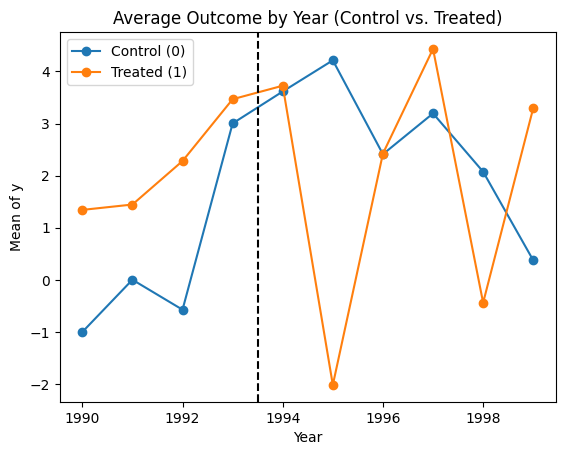

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Collapse data to mean outcome by (year, treated)
collapsed = mydata.groupby(["year", "treated"], as_index=False)["y"].mean()

# 2) Pivot so each column is a treated-status group
pivoted = collapsed.pivot(index="year", columns="treated", values="y")

# 3) Plot and add a vertical line at the treatment cutoff (1994)
pivoted.plot(marker='o')
plt.axvline(x=1993.5, linestyle='--', color='black')  # ~ splits 1993 and 1994
plt.title("Average Outcome by Year (Control vs. Treated)")
plt.xlabel("Year")
plt.ylabel("Mean of y")
plt.legend(["Control (0)", "Treated (1)"])
plt.show()

In [36]:
import pandas as pd
from pyfixest import feols, etable

# 1. Load data
url = "http://dss.princeton.edu/training/Panel101.dta"
mydata = pd.read_stata(url)

# 2. Create DiD variables
mydata['y'] = mydata['y'] / 1_000_000_000
mydata['post'] = (mydata['year'] >= 1994).astype(int)
mydata['treated'] = mydata['country'].isin(['E', 'F', 'G']).astype(int)
display(mydata.sample(10))

# 3. Estimate models with various vcov options and adding control variables
models = [
    feols("y ~ treated*post + x1 + x2 + x3 + op + opinion", data=mydata, vcov="HC3"),
    feols("y ~ treated*post + x1 + x2 + x3 + op + opinion", data=mydata, vcov={"CRV1": "country"}),
]

etable(
    models,
    #headers=["IID", "HC3", "1-Way Cluster", "2-Way Cluster"],
    #keep="treated:post",  # This will only display the DiD coefficient in the table
    signif_code=[0.01, 0.05, 0.10]
)

,country,year,y,y_bin,x1,x2,x3,opinion,op,post,treated
0,A,1990,1.342788,1.0,0.277904,-1.107956,0.282554,Str agree,1.0,0,0
25,C,1995,1.959697,1.0,1.159484,-1.218828,0.695408,Agree,1.0,1,0
2,A,1992,-0.011234,0.0,0.363466,-0.789484,0.702523,Disag,0.0,0,0
58,F,1998,-4.671724,0.0,0.788309,-0.755652,0.733478,Agree,1.0,1,1
33,D,1993,5.067265,1.0,0.209444,1.614977,-0.212578,Str agree,1.0,0,0
66,G,1996,0.254524,1.0,0.781075,-1.328000,4.278224,Str agree,1.0,1,1
35,D,1995,8.827007,1.0,0.242086,1.541221,-0.184131,Agree,1.0,1,0
60,G,1990,1.342788,1.0,0.944882,-1.515015,1.452657,Str disag,0.0,0,1
37,D,1997,5.090524,1.0,0.359426,1.874287,0.087868,Str agree,1.0,1,0
17,B,1997,1.786852,1.0,0.880167,1.502196,-0.576268,Disag,0.0,1,0


/Users/pranjal/.pyenv/versions/3.11.5/lib/python3.11/site-packages/pyfixest/estimation/feols_.py:2545: UserWarning: 
            The following variables are collinear: ['opinion[T.Str disag]'].
            The variables are dropped from the model.
            
  warnings.warn(
/Users/pranjal/.pyenv/versions/3.11.5/lib/python3.11/site-packages/pyfixest/estimation/feols_.py:2545: UserWarning: 
            The following variables are collinear: ['opinion[T.Str disag]'].
            The variables are dropped from the model.
            
  warnings.warn(


GT(_tbl_data=   level_0           level_1                     0                      1
0     coef           treated   2.537* <br> (1.369)     2.537 <br> (1.739)
1     coef              post   2.170* <br> (1.099)   2.170** <br> (0.759)
2     coef                x1    0.750 <br> (1.114)     0.750 <br> (0.494)
3     coef                x2    0.014 <br> (0.378)     0.014 <br> (0.454)
4     coef                x3   -0.221 <br> (0.336)    -0.221 <br> (0.388)
5     coef                op    0.315 <br> (0.971)     0.315 <br> (0.661)
6     coef  opinion[T.Agree]   -1.874 <br> (1.651)   -1.874* <br> (0.839)
7     coef  opinion[T.Disag]    1.395 <br> (0.972)    1.395* <br> (0.704)
8     coef      treated:post  -3.189* <br> (1.793)  -3.189** <br> (1.164)
9     coef         Intercept   -0.178 <br> (1.164)    -0.178 <br> (0.763)
10   stats      Observations                    70                     70
11   stats         S.E. type                hetero            by: country
12   stats     R<sup>2</sup>                 0.180                  0.180, _body=<great_tables._gt_data.Body object at 0x348711e10>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x3488c1a50>, _spanners=Spanners([SpannerInfo(spanner_id='y', spanner_level=1, spanner_label='y', spanner_units=None, spanner_pattern=None, vars=['0', '1'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=['Significance levels: * p < 0.1, ** p < 0.05, *** p < 0.01. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x34878e250>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value',

# Card's Minimum Wage Study

In [39]:
import pandas as pd
from pyfixest import feols, etable

# 1. Read CSV (ensure "NA" is recognized as missing)
df = pd.read_csv("data/fast_food.csv", na_values=["NA"])

# 2. Compute FTE measures in the wide data
#    (FTE = full-time + managers + 0.5*part-time)
df['fte_before'] = df['empft'] + df['nmgrs'] + 0.5*df['emppt']
df['fte_after']  = df['empft2'] + df['nmgrs2'] + 0.5*df['emppt2']

# 3. Reshape wide -> long, stacking before/after
df_before = df.copy()
df_before['fte_period'] = df_before['fte_before']
df_before['post'] = 0

df_after = df.copy()
df_after['fte_period'] = df_after['fte_after']
df_after['post'] = 1

long_df = pd.concat([df_before, df_after], ignore_index=True)

# 4. 'treated' = 1 if NJ (state=1), else 0 if PA (state=0)
long_df['treated'] = (long_df['state'] == 1).astype(int)

# 5. Estimate DiD:
#    - Base specification: FTE on treated*post
#    - With covariates: adds chain dummies & co_owned
model_base = feols(
    "fte_period ~ treated*post",
    data=long_df,
    vcov="HC3"
)

model_cov = feols(
    "fte_period ~ treated*post + C(chain) + co_owned",
    data=long_df,
    vcov="HC3"
)

# 6. Display both results side by side
etable(
    [model_base, model_cov],
    headers=["No Covariates", "Covariates (chain, co_owned)"],
    signif_code=[0.01, 0.05, 0.10]
)


GT(_tbl_data=   level_0        level_1                       0                        1
0     coef        treated   -2.892** <br> (1.456)     -2.377* <br> (1.292)
1     coef           post     -2.166 <br> (1.663)      -2.224 <br> (1.454)
2     coef   treated:post      2.754 <br> (1.816)      2.845* <br> (1.599)
3     coef  C(chain)[T.2]                          -10.453*** <br> (0.648)
4     coef  C(chain)[T.3]                             -1.625* <br> (0.864)
5     coef  C(chain)[T.4]                              -1.064 <br> (0.984)
6     coef       co_owned                             -1.169* <br> (0.643)
7     coef      Intercept  23.331*** <br> (1.363)   25.951*** <br> (1.362)
8    stats   Observations                     794                      794
9    stats      S.E. type                  hetero                   hetero
10   stats  R<sup>2</sup>                   0.007                    0.196, _body=<great_tables._gt_data.Body object at 0x34884a6d0>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x34888cc10>, _spanners=Spanners([SpannerInfo(spanner_id='fte_period', spanner_level=1, spanner_label='fte_period', spanner_units=None, spanner_pattern=None, vars=['0', '1'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=['Significance levels: * p < 0.1, ** p < 0.05, *** p < 0.01. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x348961950>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_borde